# Майнор ВШЭ 

## Прикладные задачи анализа данных 2020

## Семинар 1: Рекомендательные системы

## План семинара
- [Часть 0. Загрузка данных](#Часть-0.-Загрузка-данных)
    - [Предобработка данных](#Предобработка-данных)
- [Часть 1: Baseline (модель по популярности)](#Часть-1:-Baseline-(модель-по-популярности))
- [Часть 2. Коллаборативная фильтрация](#Часть-2.-Коллаборативная-фильтрация)
    - [Memory-based](#Memory-based)
    - [Модель со скрытыми переменными](#Модель-со-скрытыми-переменными)
- [Часть 3. Контентные модели](#Часть-3.-Контентные-модели)
- [Часть 4. Факторизационная машина](#Часть-4.-Факторизационная-машина)

На этом семинаре мы рассмотрим основные подходы к задаче рекомендации и увидим, как это выглядит на практике на небольшом датасете.

Воспользуемся датасетом: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [1]:
%pylab inline

import pandas as pd

from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим [Deskdrop dataset](https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip), включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

In [ ]:
# загружаем и разархивируем данные, для вашего удобства данные можно найти по ссылке: 
# https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip 
# в Colab и linux вам могут пригодиться утилиты wget и unzip
# также, если вы работаете в Google Colab, устанавливаем библиотеки, которые потребуеются дальше: pyfm, catboost
####### Здесь ваш код ##########
!pip3 -q install cython
!pip3 -q install git+https://github.com/coreylynch/pyFM
!pip3 -q install catboost
!wget -q -N https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip 
!unzip -o -q articles-sharing-reading-from-cit-deskdrop.zip
!ls *.csv
################################

#### shared_articles.csv

In [2]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [3]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

In [4]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [5]:
interactions_df['eventType'].unique()

array(['VIEW', 'FOLLOW', 'BOOKMARK', 'LIKE', 'COMMENT CREATED'],
      dtype=object)

В колонке `eventType` описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

Посмотрим информацию о `interactions_df`

In [6]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
timestamp      72312 non-null int64
eventType      72312 non-null object
contentId      72312 non-null int64
personId       72312 non-null int64
sessionId      72312 non-null int64
userAgent      56918 non-null object
userRegion     56907 non-null object
userCountry    56918 non-null object
dtypes: int64(4), object(4)
memory usage: 4.4+ MB


Признаки `personId`, `contentId` представлены в `int64`. Преобразуем в `str`.

In [7]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)

interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
timestamp      72312 non-null int64
eventType      72312 non-null object
contentId      72312 non-null object
personId       72312 non-null object
sessionId      72312 non-null int64
userAgent      56918 non-null object
userRegion     56907 non-null object
userCountry    56918 non-null object
dtypes: int64(2), object(6)
memory usage: 4.4+ MB


Проделаем то же самое с `articles_df`.

In [8]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3047 entries, 1 to 3121
Data columns (total 13 columns):
timestamp          3047 non-null int64
eventType          3047 non-null object
contentId          3047 non-null int64
authorPersonId     3047 non-null int64
authorSessionId    3047 non-null int64
authorUserAgent    669 non-null object
authorRegion       669 non-null object
authorCountry      669 non-null object
contentType        3047 non-null object
url                3047 non-null object
title              3047 non-null object
text               3047 non-null object
lang               3047 non-null object
dtypes: int64(4), object(9)
memory usage: 333.3+ KB


In [9]:
articles_df.contentId = articles_df.contentId.astype(str)

articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3047 entries, 1 to 3121
Data columns (total 13 columns):
timestamp          3047 non-null int64
eventType          3047 non-null object
contentId          3047 non-null object
authorPersonId     3047 non-null int64
authorSessionId    3047 non-null int64
authorUserAgent    669 non-null object
authorRegion       669 non-null object
authorCountry      669 non-null object
contentType        3047 non-null object
url                3047 non-null object
title              3047 non-null object
text               3047 non-null object
lang               3047 non-null object
dtypes: int64(3), object(10)
memory usage: 333.3+ KB


### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [10]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [11]:
# interactions_df['eventStrength'] =
####### Здесь ваш код ##########
interactions_df['eventStrength'] = interactions_df['eventType'].map(event_type_strength)
################################

interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

In [12]:
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [13]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())

print('# users:', len(users_interactions_count_df))

# users: 1895


In [14]:
users_interactions_count_df

personId
-1007001694607905623      6
-1032019229384696495    648
-108842214936804958     270
-1093393486211919385      2
-1110220372195277179      3
                       ... 
987030274299018507        3
989049974880576288       19
98958074799194811         4
997469202936578234       17
998688566268269815        6
Length: 1895, dtype: int64

In [15]:
users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]

print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1140


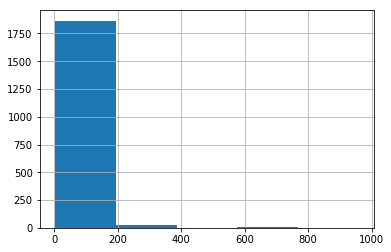

In [16]:
users_interactions_count_df.hist(bins=5)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей. (Можно воспользоваться функцией `np.isin`.)

In [17]:
# interactions_from_selected_users_df =
####### Здесь ваш код ##########
interactions_from_selected_users_df = interactions_df.loc[np.isin(interactions_df['personId'],
            users_with_enough_interactions_df)]
################################

In [18]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия (`timestamp`) для разделениея выборки на обучение и контроль.

In [19]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['eventStrength'].sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)

interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(10)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [20]:
split_ts = 1475519530

interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
from sklearn.model_selection import train_test_split

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.25,
                                   random_state=42)

```
Как повлият такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказанями в виде списков.

In [21]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions['true_test']), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions['true_test']), 'true_test']))]

interactions.head(100)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]
...,...,...
-2901997243166418276,"[-1038011342017850, -1192619987285372590, -129...","[-2164628725543527116, -6584408680441477889, -..."
-2902404120792546116,[834896074125772354],"[-1572252285162838958, 3091351089612339864, 32..."
-290301761563498796,"[-1297580205670251233, -133139342397538859, -2...","[-1425776303341065806, -4029704725707465084, -..."


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы. 

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности. Работать будем с `interactions_train_df`.

In [22]:
# popular_content =
####### Здесь ваш код ##########
popular_content = (
    interactions_train_df
    .groupby('contentId')['eventStrength'].sum().reset_index()
    .sort_values('eventStrength', ascending=False)['contentId'].values
)
################################
popular_content

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', ..., '6240076106289531207',
       '6541551984368289722', '7083316110921342538'], dtype=object)

In [23]:
print(articles_df.loc[articles_df.contentId == popular_content[2]]['title'].values)

["Ray Kurzweil: The world isn't getting worse - our information is getting better"]


In [24]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в `true_train`).

In [25]:
interactions

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]
...,...,...
953707509720613429,"[-1068603220639552685, -2358756719610361882, -...","[-2402288292108892893, -5813211845057621660, -..."
983095443598229476,"[-133139342397538859, -8742648016180281673]","[-14569272361926584, -1572252285162838958, -18..."
989049974880576288,"[-133139342397538859, -2038869595290705317, -2...","[-6289909056857931861, -7047448754687279385, -..."


In [26]:
top_k = 10

# interactions['prediction_popular'] =
####### Здесь ваш код ##########
interactions['prediction_popular'] = (
    interactions['true_train'].apply(lambda x: popular_content[~np.isin(popular_content, x)][:top_k])
)
################################

interactions.head(2)

,true_train,true_test,prediction_popular
personId,,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72...","[-6783772548752091658, -133139342397538859, -8..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -...","[-6783772548752091658, -133139342397538859, -8..."


In [27]:
interactions['prediction_popular'][0]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

Настало время оценить качество. Посчитаем **precision@10** для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

$$Precision@k = \frac{1}{k}\sum_{i=1}^{k} I\left(d \right)$$

$I\left(d \right) \in \left\{0, 1\right\}$, $I\left(d \right)$ — индикатор релевантности документа, $d$ — документ

In [28]:
def calc_precision(column):
    ####### Здесь ваш код ##########
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()
    ################################

In [29]:
calc_precision('prediction_popular')

0.006454207722621084

## Часть 2. Коллаборативная фильтрация

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [34]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [37]:
ratings.head()

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
-1032019229384696495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0
-108842214936804958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,0.0,0.0
-1130272294246983140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
-1160159014793528221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Memory-based

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от **pandas** к **numpy**.

In [38]:
ratings_m = ratings.values

In [39]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
            
        # similarity_users[i,j] = 
        # similarity_users[j,i] = 
        ####### Здесь ваш код ##########
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]
        ################################

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в `interactions`), посчитаем качество по уже использованной метрике.

In [40]:
prediction_user_based = []
####### Здесь ваш код ##########
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        
        recommend = np.array(tmp_recommend)[~np.isin(tmp_recommend, interactions.iloc[i])][:10]
        
        prediction_user_based.append(list(recommend))
################################
interactions['prediction_user_based'] = prediction_user_based

C:\Users\mi\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [41]:
calc_precision('prediction_user_based')

0.003541692918885617

### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (`svd` в `scipy.linalg`) для `ratings`, на выходе получим три матрицы.

Заметим, что мы используем матрицу с нулями, будто отсутствующие взаимодействия негативные, что странно.

Если бы мы учили модель со скрытыми переменными с помощью стохастического градиентного спуска, то неизвестные взаимодействия могли бы не использовать.

In [42]:
from scipy.linalg import svd

In [43]:
####### Здесь ваш код ##########
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)
################################

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [44]:
####### Здесь ваш код ##########
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
################################

8.458724845297917e-25


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице $U$, оставить из $sigma$ только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице $V$. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [45]:
K = 100
####### Здесь ваш код ##########
sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)
################################

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [46]:
####### Здесь ваш код ##########
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))
################################

25843.42489891277
78622.13000466056


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [47]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
####### Здесь ваш код ##########
for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.isin(prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
################################
interactions['prediction_svd'] = predictions

In [48]:
calc_precision('prediction_svd')

0.012212989310270754

## Часть 3. Контентные модели

В этой части реализуем альтернативных подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части. 

Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные.

Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [49]:
test_personId = np.repeat(interactions.index, len(ratings.columns)) 
test_contentId = list(ratings.columns) * len(interactions)

test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[np.random.permutation(test.index)[:4*len(interactions_train_df)]]), ignore_index=True, sort=True)

interactions_train_df['eventStrength'].fillna(0, inplace=True)

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [50]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [51]:
# first feature index
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [52]:
test_personId = np.repeat(interactions.index, len(articles_df)) 
test_contentId = list(articles_df.contentId) * len(interactions)

test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений `contentType`.

In [53]:
interactions_train_df['is_HTML'] = interactions_train_df['contentType'] == 'HTML'

####### Здесь ваш код ##########
interactions_train_df['is_RICH'] = interactions_train_df['contentType'] == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df['contentType'] == 'VIDEO'

test['is_HTML'] = test['contentType'] == 'HTML'
test['is_RICH'] = test['contentType'] == 'RICH'
test['is_VIDEO'] = test['contentType'] == 'VIDEO'
################################

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова (new, why, how, ai).

In [54]:
interactions_train_df['title_length'] = interactions_train_df['title'].fillna('').apply(len)

####### Здесь ваш код ##########
interactions_train_df['text_length'] = interactions_train_df['text'].fillna('').apply(len)

test['title_length'] = test['title'].fillna('').apply(len)
test['text_length'] = test['text'].fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df['title'].fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df['title'].fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df['title'].fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df['title'].fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test['title'].fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test['title'].fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test['title'].fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test['title'].fillna('').apply(lambda x: 'ai' in x.lower())
################################

Добавим признаки-индикаторы языка.

In [55]:
interactions_train_df['is_lang_en'] = interactions_train_df['lang'] == 'en'

####### Здесь ваш код ##########
interactions_train_df['is_lang_pt'] = interactions_train_df['lang'] == 'pt'

test['is_lang_en'] = test['lang'] == 'en'
test['is_lang_pt'] = test['lang'] == 'pt'
################################

Обучим на полученных признаках градиентный бустинг.

In [56]:
import catboost 

model = catboost.CatBoostClassifier()

model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.068735
0:	learn: 0.6652404	total: 120ms	remaining: 1m 59s
1:	learn: 0.6409615	total: 162ms	remaining: 1m 21s
2:	learn: 0.6205150	total: 188ms	remaining: 1m 2s
3:	learn: 0.6029438	total: 220ms	remaining: 54.9s
4:	learn: 0.5876624	total: 258ms	remaining: 51.4s
5:	learn: 0.5745231	total: 302ms	remaining: 50s
6:	learn: 0.5633933	total: 335ms	remaining: 47.6s
7:	learn: 0.5536107	total: 374ms	remaining: 46.3s
8:	learn: 0.5455481	total: 409ms	remaining: 45.1s
9:	learn: 0.5386732	total: 439ms	remaining: 43.4s
10:	learn: 0.5327859	total: 465ms	remaining: 41.8s
11:	learn: 0.5275126	total: 505ms	remaining: 41.5s
12:	learn: 0.5229317	total: 544ms	remaining: 41.3s
13:	learn: 0.5192336	total: 568ms	remaining: 40s
14:	learn: 0.5158439	total: 607ms	remaining: 39.8s
15:	learn: 0.5128339	total: 645ms	remaining: 39.7s
16:	learn: 0.5102146	total: 682ms	remaining: 39.4s
17:	learn: 0.5081048	total: 737ms	remaining: 40.2s
18:	learn: 0.5063607	total: 770ms	remaining: 39.7s
19:	learn: 0.

160:	learn: 0.4805905	total: 6.18s	remaining: 32.2s
161:	learn: 0.4805204	total: 6.22s	remaining: 32.2s
162:	learn: 0.4804550	total: 6.25s	remaining: 32.1s
163:	learn: 0.4803656	total: 6.29s	remaining: 32.1s
164:	learn: 0.4802792	total: 6.33s	remaining: 32s
165:	learn: 0.4801668	total: 6.37s	remaining: 32s
166:	learn: 0.4801050	total: 6.41s	remaining: 32s
167:	learn: 0.4800769	total: 6.44s	remaining: 31.9s
168:	learn: 0.4799931	total: 6.48s	remaining: 31.9s
169:	learn: 0.4799452	total: 6.52s	remaining: 31.8s
170:	learn: 0.4798677	total: 6.56s	remaining: 31.8s
171:	learn: 0.4798040	total: 6.6s	remaining: 31.8s
172:	learn: 0.4797166	total: 6.64s	remaining: 31.7s
173:	learn: 0.4796785	total: 6.67s	remaining: 31.7s
174:	learn: 0.4796037	total: 6.71s	remaining: 31.6s
175:	learn: 0.4795632	total: 6.74s	remaining: 31.6s
176:	learn: 0.4795155	total: 6.78s	remaining: 31.5s
177:	learn: 0.4794162	total: 6.81s	remaining: 31.5s
178:	learn: 0.4793364	total: 6.85s	remaining: 31.4s
179:	learn: 0.47919

319:	learn: 0.4714229	total: 12.5s	remaining: 26.7s
320:	learn: 0.4713667	total: 12.6s	remaining: 26.6s
321:	learn: 0.4713035	total: 12.6s	remaining: 26.6s
322:	learn: 0.4712564	total: 12.7s	remaining: 26.6s
323:	learn: 0.4711974	total: 12.7s	remaining: 26.6s
324:	learn: 0.4711630	total: 12.8s	remaining: 26.6s
325:	learn: 0.4711348	total: 12.8s	remaining: 26.5s
326:	learn: 0.4710942	total: 12.9s	remaining: 26.5s
327:	learn: 0.4710418	total: 12.9s	remaining: 26.5s
328:	learn: 0.4709841	total: 13s	remaining: 26.4s
329:	learn: 0.4709413	total: 13s	remaining: 26.4s
330:	learn: 0.4708864	total: 13s	remaining: 26.4s
331:	learn: 0.4708562	total: 13.1s	remaining: 26.3s
332:	learn: 0.4707953	total: 13.1s	remaining: 26.3s
333:	learn: 0.4707401	total: 13.2s	remaining: 26.3s
334:	learn: 0.4707024	total: 13.2s	remaining: 26.2s
335:	learn: 0.4706615	total: 13.3s	remaining: 26.2s
336:	learn: 0.4706166	total: 13.3s	remaining: 26.2s
337:	learn: 0.4705436	total: 13.4s	remaining: 26.2s
338:	learn: 0.4705

478:	learn: 0.4652850	total: 20.1s	remaining: 21.9s
479:	learn: 0.4652748	total: 20.1s	remaining: 21.8s
480:	learn: 0.4652497	total: 20.2s	remaining: 21.8s
481:	learn: 0.4652375	total: 20.2s	remaining: 21.7s
482:	learn: 0.4652172	total: 20.3s	remaining: 21.7s
483:	learn: 0.4651789	total: 20.3s	remaining: 21.7s
484:	learn: 0.4651671	total: 20.4s	remaining: 21.6s
485:	learn: 0.4651557	total: 20.4s	remaining: 21.6s
486:	learn: 0.4651295	total: 20.5s	remaining: 21.6s
487:	learn: 0.4651004	total: 20.5s	remaining: 21.5s
488:	learn: 0.4650837	total: 20.6s	remaining: 21.5s
489:	learn: 0.4650572	total: 20.6s	remaining: 21.4s
490:	learn: 0.4650251	total: 20.7s	remaining: 21.4s
491:	learn: 0.4649926	total: 20.7s	remaining: 21.4s
492:	learn: 0.4649375	total: 20.8s	remaining: 21.3s
493:	learn: 0.4649159	total: 20.8s	remaining: 21.3s
494:	learn: 0.4648854	total: 20.8s	remaining: 21.3s
495:	learn: 0.4648458	total: 20.9s	remaining: 21.2s
496:	learn: 0.4647881	total: 20.9s	remaining: 21.2s
497:	learn: 

637:	learn: 0.4607989	total: 27.5s	remaining: 15.6s
638:	learn: 0.4607711	total: 27.5s	remaining: 15.5s
639:	learn: 0.4607421	total: 27.6s	remaining: 15.5s
640:	learn: 0.4607178	total: 27.6s	remaining: 15.5s
641:	learn: 0.4606985	total: 27.6s	remaining: 15.4s
642:	learn: 0.4606790	total: 27.7s	remaining: 15.4s
643:	learn: 0.4606559	total: 27.7s	remaining: 15.3s
644:	learn: 0.4606031	total: 27.8s	remaining: 15.3s
645:	learn: 0.4605607	total: 27.8s	remaining: 15.2s
646:	learn: 0.4605410	total: 27.9s	remaining: 15.2s
647:	learn: 0.4605188	total: 27.9s	remaining: 15.2s
648:	learn: 0.4604764	total: 27.9s	remaining: 15.1s
649:	learn: 0.4604396	total: 28s	remaining: 15.1s
650:	learn: 0.4604009	total: 28s	remaining: 15s
651:	learn: 0.4603879	total: 28.1s	remaining: 15s
652:	learn: 0.4603798	total: 28.1s	remaining: 14.9s
653:	learn: 0.4603553	total: 28.2s	remaining: 14.9s
654:	learn: 0.4603376	total: 28.2s	remaining: 14.9s
655:	learn: 0.4603202	total: 28.2s	remaining: 14.8s
656:	learn: 0.460279

796:	learn: 0.4573282	total: 34.9s	remaining: 8.9s
797:	learn: 0.4573218	total: 35s	remaining: 8.86s
798:	learn: 0.4572929	total: 35s	remaining: 8.81s
799:	learn: 0.4572749	total: 35.1s	remaining: 8.77s
800:	learn: 0.4572572	total: 35.1s	remaining: 8.73s
801:	learn: 0.4572230	total: 35.2s	remaining: 8.69s
802:	learn: 0.4571821	total: 35.2s	remaining: 8.64s
803:	learn: 0.4571719	total: 35.3s	remaining: 8.6s
804:	learn: 0.4571635	total: 35.3s	remaining: 8.56s
805:	learn: 0.4571327	total: 35.4s	remaining: 8.51s
806:	learn: 0.4571191	total: 35.4s	remaining: 8.47s
807:	learn: 0.4571121	total: 35.5s	remaining: 8.43s
808:	learn: 0.4570766	total: 35.5s	remaining: 8.38s
809:	learn: 0.4570205	total: 35.6s	remaining: 8.34s
810:	learn: 0.4570098	total: 35.6s	remaining: 8.3s
811:	learn: 0.4569959	total: 35.7s	remaining: 8.26s
812:	learn: 0.4569882	total: 35.7s	remaining: 8.22s
813:	learn: 0.4569807	total: 35.8s	remaining: 8.18s
814:	learn: 0.4569680	total: 35.9s	remaining: 8.14s
815:	learn: 0.45694

955:	learn: 0.4545870	total: 42.2s	remaining: 1.94s
956:	learn: 0.4545616	total: 42.3s	remaining: 1.9s
957:	learn: 0.4545591	total: 42.3s	remaining: 1.85s
958:	learn: 0.4545454	total: 42.3s	remaining: 1.81s
959:	learn: 0.4545333	total: 42.4s	remaining: 1.76s
960:	learn: 0.4545212	total: 42.4s	remaining: 1.72s
961:	learn: 0.4544926	total: 42.5s	remaining: 1.68s
962:	learn: 0.4544770	total: 42.5s	remaining: 1.63s
963:	learn: 0.4544714	total: 42.5s	remaining: 1.59s
964:	learn: 0.4544433	total: 42.6s	remaining: 1.54s
965:	learn: 0.4544379	total: 42.6s	remaining: 1.5s
966:	learn: 0.4544265	total: 42.7s	remaining: 1.46s
967:	learn: 0.4544193	total: 42.7s	remaining: 1.41s
968:	learn: 0.4544062	total: 42.8s	remaining: 1.37s
969:	learn: 0.4543991	total: 42.8s	remaining: 1.32s
970:	learn: 0.4543790	total: 42.9s	remaining: 1.28s
971:	learn: 0.4543649	total: 42.9s	remaining: 1.24s
972:	learn: 0.4543493	total: 43s	remaining: 1.19s
973:	learn: 0.4543303	total: 43s	remaining: 1.15s
974:	learn: 0.4543

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации. 

In [57]:
####### Здесь ваш код ##########
predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
    
interactions['prediction_content'] = tmp_predictions
################################

Оценим их качество.

In [58]:
# calc_precision(...)
####### Здесь ваш код ##########
calc_precision('prediction_content')
################################

0.008966241961349004

## Часть 4. Факторизационная машина

Вспомним, что факторизационная машина учитывает попарные взаимодействия признаков, что приводит сразу и к использованию контента (сами признаки), и к обучению скрытых представлений (индикаторы пользователей и статей).

Попробуем факторизационные машины из библиотеки pyFM (так как можно работать прямо из питона). https://github.com/coreylynch/pyFM

In [1]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

Перейдём к обобщению матричных разложений — факторизационным машинам, которые работают с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить **id** пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (**id** и другие) с помощью `DictVectorizer`. Например, процесс может выглядить вот так:
```python
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)

y = np.repeat(1.0, X.shape[0])

fm = pylibfm.FM()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))
```

Сгенерируем таблицу с признаками в таком виде, где будут **id** пользователя, статьи и автора статьи и несколько других признаков (попробуйте придумать).

In [ ]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i]['personId'])
    features['contentId'] = str(interactions_train_df.iloc[i]['contentId'])
    
    ####### Здесь ваш код ##########
    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article['authorPersonId'])
        features['authorCountry'] = str(article['authorCountry'])
        features['lang'] = str(article['lang'])
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'
    ################################
    train_data.append(features)

Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [ ]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):
        
        ####### Здесь ваш код ##########
        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articles_df.loc[features['contentId']]
            features['authorId'] = str(article['authorPersonId'])
            features['authorCountry'] = str(article['authorCountry'])
            features['lang'] = str(article['lang'])
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'
        ################################
        test_data.append(deepcopy(features))

Векторизуем, получим разреженные матрицы.

Мы будем обучать регрессор на силу взаимодействия, а для него нужны отрицательные примеры. Добавим некоторое количество случайных примеров как негативные (матрица взаимодействий разреженная, поэтому шансы взять как негативное взаимодействие некоторое положительное мало).

In [ ]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))

test_features = dv.transform(test_data)

In [ ]:
train_features

In [ ]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

Укажем размером скрытого представления 10, сделаем 10 итераций.

In [ ]:
# fm = pylibfm.FM(...
####### Здесь ваш код ##########
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')
################################
fm.fit(train_features, y_train)

Предскажем и оценим качество.

In [ ]:
####### Здесь ваш код ##########
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))
################################

In [ ]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [ ]:
calc_precision('fm_prediction')